## K-MEANS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist

file_path = "online_gaming_behavior_dataset.csv"
df = pd.read_csv(file_path)

print(df.info())
print("Available Columns:", df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

In [24]:
from sklearn.calibration import LabelEncoder

# Drop irrelevant column
df = df.drop(columns=["PlayerID"], errors='ignore')

# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Standardize numerical features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)


K-Means Silhouette Score: 0.1184
K-Means Davies-Bouldin Score: 2.4687

Cluster Summary:
                Age    Gender  Location  GameGenre  PlayTimeHours  \
Cluster                                                            
0        31.987544  0.605132  1.679621   2.037992      11.937299   
1        31.869916  0.588568  1.692298   2.010108      12.112241   
2        32.037221  0.599679  1.701848   1.985356      12.023046   

         InGamePurchases  GameDifficulty  SessionsPerWeek  \
Cluster                                                     
0               1.000000        0.806926         9.515820   
1               0.001564        0.796992        14.591937   
2               0.000000        0.798827         7.661251   

         AvgSessionDurationMinutes  PlayerLevel  AchievementsUnlocked  \
Cluster                                                                 
0                        94.364350    50.017439             24.513577   
1                       134.389049    50.7903

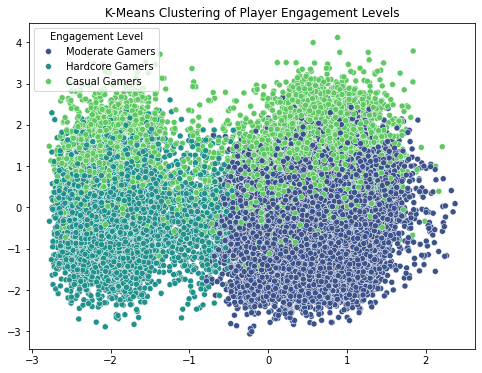

In [ ]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df_scaled)

# Evaluate K-Means Clustering
kmeans_silhouette = silhouette_score(df_scaled, df["Cluster"])
kmeans_davies_bouldin = davies_bouldin_score(df_scaled, df["Cluster"])

print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")
print(f"K-Means Davies-Bouldin Score: {kmeans_davies_bouldin:.4f}")

# Analyze Cluster Composition
cluster_summary = df.groupby("Cluster").mean()
print("\nCluster Summary:\n", cluster_summary)

# Define Alternative Engagement Feature
engagement_feature = "PlayTimeHours"  # Best available engagement feature

print(f"Using {engagement_feature} for engagement level classification.")

# Assign cluster labels based on engagement feature
max_cluster = cluster_summary[engagement_feature].idxmax()  # Highest engagement
min_cluster = cluster_summary[engagement_feature].idxmin()  # Lowest engagement

# Find the "moderate" cluster closest to the median value
median_value = cluster_summary[engagement_feature].median()
moderate_cluster = (cluster_summary[engagement_feature] - median_value).abs().idxmin()

cluster_labels = {
    max_cluster: "Hardcore Gamers",
    min_cluster: "Casual Gamers",
    moderate_cluster: "Moderate Gamers"
}

df["Engagement Level"] = df["Cluster"].map(cluster_labels)

# Reduce Data to 2D for Visualization Using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_scaled)

# Visualize K-Means Clustering with Engagement Labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df["Engagement Level"], palette="viridis")
plt.title("K-Means Clustering of Player Engagement Levels")
plt.show()

### checking best k for silhouette score

## DBSCAN

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist

file_path = "online_gaming_behavior_dataset.csv"  
df = pd.read_csv(file_path)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = df.drop(columns=['PlayerID'])

categorical_cols = ['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col])

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

df_scaled.head()


,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,1.096023,0.819108,0.256009,1.412273,0.614176,-0.501334,1.376416,-0.602363,0.269487,1.026459,0.032814,0.931300
1,-0.297969,-1.220840,1.096511,1.412273,-0.939816,-0.501334,1.376416,-0.775865,1.004019,-1.352160,-1.006648,0.931300
2,-0.994965,-1.220840,1.096511,0.705766,-0.549654,-0.501334,-0.917744,1.132666,0.963212,-0.512647,1.141573,-1.474409
3,0.299456,0.819108,1.096511,-1.413756,-0.977506,1.994676,-0.917744,-0.081854,-0.199798,0.256906,1.557358,0.931300
4,0.100314,0.819108,-0.584492,-1.413756,0.507275,-0.501334,1.376416,-1.296374,0.738771,1.586134,0.864383,0.931300


DBSCAN Silhouette Score: 0.5565806244352465
DBSCAN Davies-Bouldin Score: 0.631994778313133


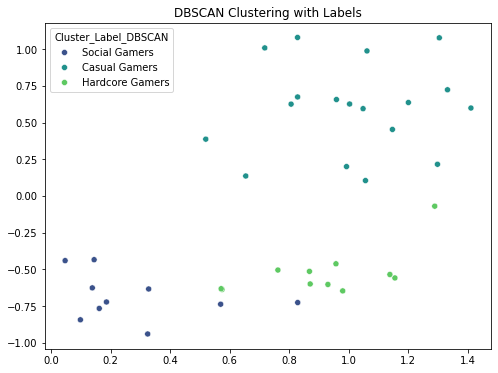

In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN Clustering
dbscan = DBSCAN(eps=1.06, min_samples=10)  
df_scaled["Cluster_DBSCAN"] = dbscan.fit_predict(df_scaled)

# Assign Labels (Mark -1 as "Noise")
cluster_labels_dbscan = {
    0: "Casual Gamers",
    1: "Hardcore Gamers",
    2: "Social Gamers"
}
df_scaled["Cluster_Label_DBSCAN"] = df_scaled["Cluster_DBSCAN"].map(cluster_labels_dbscan)

valid_clusters = df_scaled[df_scaled["Cluster_DBSCAN"] != -1]
if len(valid_clusters) > 0:
    silhouette_dbscan = silhouette_score(valid_clusters.drop(columns=['Cluster_DBSCAN', 'Cluster_Label_DBSCAN']), valid_clusters["Cluster_DBSCAN"])
    davies_bouldin_dbscan = davies_bouldin_score(valid_clusters.drop(columns=['Cluster_DBSCAN', 'Cluster_Label_DBSCAN']), valid_clusters["Cluster_DBSCAN"])
    
    print(f"DBSCAN Silhouette Score: {silhouette_dbscan}")
    print(f"DBSCAN Davies-Bouldin Score: {davies_bouldin_dbscan}")
else:
    print("DBSCAN failed to find enough clusters for evaluation.")

pca_data_dbscan = pca.fit_transform(df_scaled.drop(columns=['Cluster_DBSCAN', 'Cluster_Label_DBSCAN']))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data_dbscan[:, 0], y=pca_data_dbscan[:, 1], hue=df_scaled["Cluster_Label_DBSCAN"], palette="viridis")
plt.title("DBSCAN Clustering with Labels")
plt.show()

## HIERARCHICAL

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist


file_path = "online_gaming_behavior_dataset.csv"  
df = pd.read_csv(file_path)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = df.drop(columns=['PlayerID'])

categorical_cols = ['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col])

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

df_scaled.head()


,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,1.096023,0.819108,0.256009,1.412273,0.614176,-0.501334,1.376416,-0.602363,0.269487,1.026459,0.032814,0.931300
1,-0.297969,-1.220840,1.096511,1.412273,-0.939816,-0.501334,1.376416,-0.775865,1.004019,-1.352160,-1.006648,0.931300
2,-0.994965,-1.220840,1.096511,0.705766,-0.549654,-0.501334,-0.917744,1.132666,0.963212,-0.512647,1.141573,-1.474409
3,0.299456,0.819108,1.096511,-1.413756,-0.977506,1.994676,-0.917744,-0.081854,-0.199798,0.256906,1.557358,0.931300
4,0.100314,0.819108,-0.584492,-1.413756,0.507275,-0.501334,1.376416,-1.296374,0.738771,1.586134,0.864383,0.931300


Hierarchical Clustering Silhouette Score: 0.08100140274319712
Hierarchical Clustering Davies-Bouldin Score: 3.4236693649667225


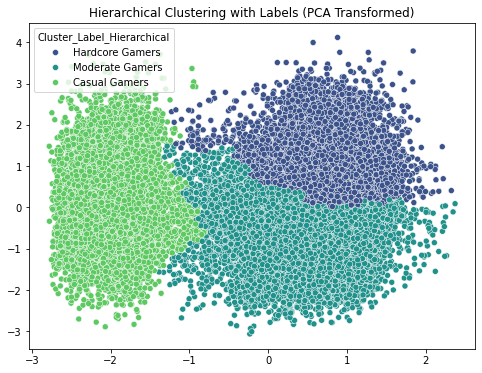

In [ ]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

linkage_matrix_pca = linkage(df_pca, method='ward')

df_scaled["Cluster_Hierarchical"] = fcluster(linkage_matrix_pca, 3, criterion='maxclust')

cluster_labels_hierarchical = {
    1: "Casual Gamers",
    2: "Hardcore Gamers",
    3: "Moderate Gamers",
}
df_scaled["Cluster_Label_Hierarchical"] = df_scaled["Cluster_Hierarchical"].map(cluster_labels_hierarchical)

silhouette_hierarchical = silhouette_score(df_scaled.drop(columns=['Cluster_Hierarchical', 'Cluster_Label_Hierarchical']), df_scaled["Cluster_Hierarchical"])
davies_bouldin_hierarchical = davies_bouldin_score(df_scaled.drop(columns=['Cluster_Hierarchical', 'Cluster_Label_Hierarchical']), df_scaled["Cluster_Hierarchical"])

print(f"Hierarchical Clustering Silhouette Score: {silhouette_hierarchical}")
print(f"Hierarchical Clustering Davies-Bouldin Score: {davies_bouldin_hierarchical}")

pca_data_hierarchical = pca.fit_transform(df_scaled.drop(columns=['Cluster_Hierarchical', 'Cluster_Label_Hierarchical']))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data_hierarchical[:, 0], y=pca_data_hierarchical[:, 1], hue=df_scaled["Cluster_Label_Hierarchical"], palette="viridis")
plt.title("Hierarchical Clustering with Labels (PCA Transformed)")
plt.show()
